In [80]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.units import rad, s, Hz

import pulsar

# Pulsar Profiling

Neutron stars have strong magnetic fields that emit beams of radiation from 
their magnetic poles. As the star rotates over its spin axis, the radiation beam
is seen once for every rotation when an observer becomes aligned with the 
star's magnetic axis.

From the point of view of an observer, the star's brightness is increased many
folds during this short period, creating a distinct pulse, hence the name
pulsating star, or pulsar. However, because the star's rotation and magnetic
axes can have different alignments, the observed brightness varies during the
precessional motion of the star.

In this project we use computational techniques to simulate and plot a pulsar
profile in which its observed brightness follows the von Mises distribution,
a continuous probability distribution on a circular plane with a range from 0
to 2 $\pi$.

$$I(\phi \, | \, \mu,\kappa) = I_{peak}e^{\kappa\, cos(\phi-\mu)}$$

Where:

* $\phi$ is the pulsar phase which depends on its angular frequency
* $I_{peak}$ is the peak observed brightness
* $\mu$ is the mean direction of the distribution ($0 \leq \mu \leq 2 \pi$)
* $\kappa$ is the concentration parameter, the reciprocal of dispersion,
defined as:

$$\kappa = \frac{log \, 2}{2\, sin^2(\pi D/2)}$$

When $\kappa = 0$ the distribution is uniform, but for a pulsar its
concentration value depends on $D$, the duty cycle. The duty cycle is the ratio
of pulse width to the period of repetition of the pulse.

Examples of duty cycles of detected pulsars (Henry and Paik, 1969):

<div>
<img src="dutycycle.png" alt="Duty Cycles" width="400px">
</div> 

References:

* Grafarend, E. & Awange. J. (2012) Applications of Linear and Nonlinear Models:
Fixed Effects, Random Effects. Springer Science & Business Media, Aug 15.
(p. 362)
* Henty, G., Paik, HJ. Distribution of Pulsar Duty Cycles. Nature 224, 1188–1189
(1969). https://doi.org/10.1038/2241188a0

## Scenario Constants

For this project we use the following constants for the observed intensity
function:

* $\phi_{0} = 1$ ($\phi$ at $t_0$)
* $I_{peak} = 100$ 
* $\mu = 1$
* $D = 0.1$
* T = 10ms 

In [81]:
# Global settings for plot size
plt.rcParams["figure.figsize"] = (20, 5)

# Pulsar scenario constants
D = 0.1           # duty cycle number
phi0 = 1 * rad    # initial angle value
Ipeak = 100       # amplitude of intensity
period = 0.01 * s # rotational period (10 ms)

## Simulated brightness time series

Using the scenario constants we simulate a time series from 0 to 2s with 200Hz
sample rate, twice the pulsar angular frequency.

The first plot shows the entire 2s period in which we can see the observed
brightness varying sharply from its peak $\approx 2.5 \cdot 10^4$ to near zero.
Therefore, from an observer the pulse increases by 4 orders of magnitude when 
the beam is in phase.

The next plots show individual pulses at its highest and lowest observed
brightness. From the first image we can see one pulse for each rotational period
(0.01s).

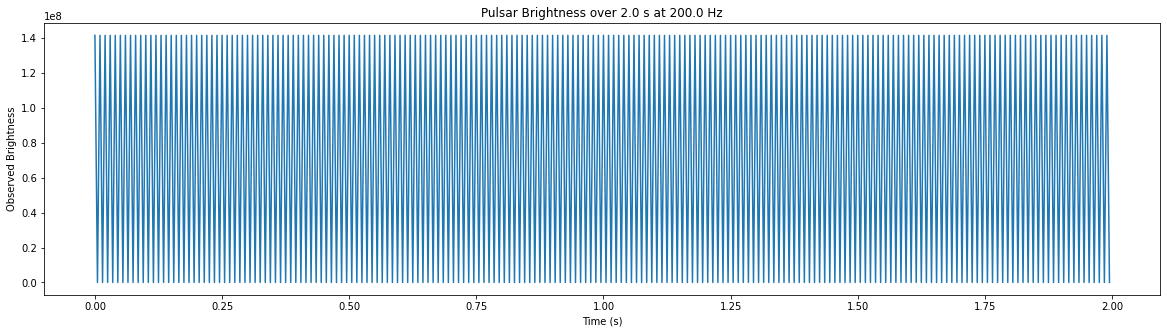

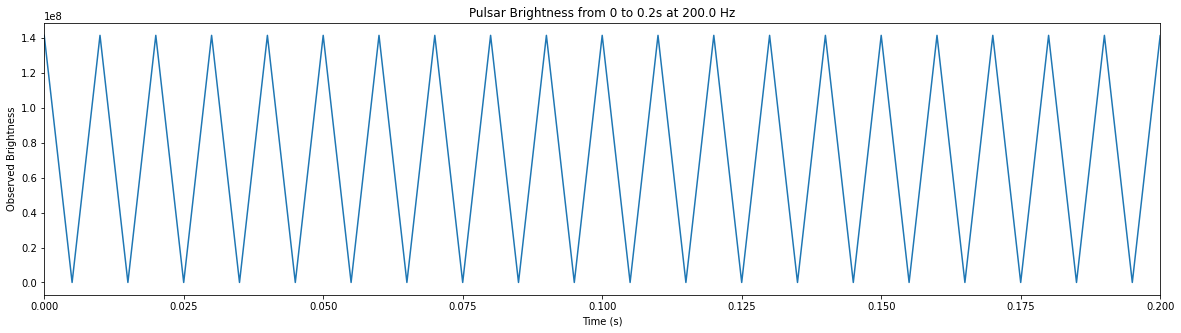

In [82]:
time = 2 * s
rate = 5e-3 * s # 5ms / 200Hz

def plot_brightness(time: s, rate: s, xlim=()):

    timeseries = np.arange(0, time.value, rate.value) * s
    brightness = pulsar.linear_brightness(phi0, D, period, Ipeak, timeseries)
    freq = (1/rate).to(Hz).round(2)

    plt.plot(timeseries, brightness)
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    if len(xlim) == 2:
        min = xlim[0]
        max = xlim[1]
        plt.xlim(xlim[0], xlim[1])
        plt.title(f'Pulsar Brightness from {min} to {max}s at {freq}')
    else:
        plt.title(f'Pulsar Brightness over {time} at {freq}')
    plt.show()

plot_brightness(time, rate)
plot_brightness(time, rate, (0, 0.20))

Using different sample rates over the same period it is possible to see how
constructive and destructive interference patterns affect the signal. When
sampling at 180 Hz instead the signal becomes less clear since the detection
is out of phase.

A sample rate of 100Hz or below produces a continuous signal.

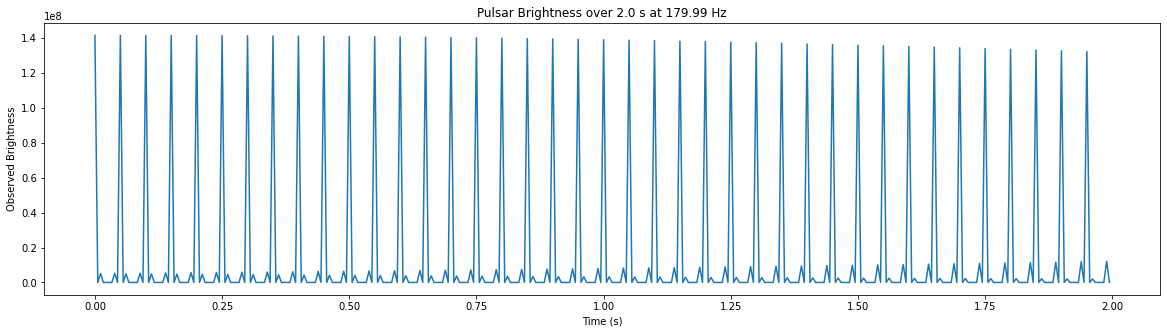

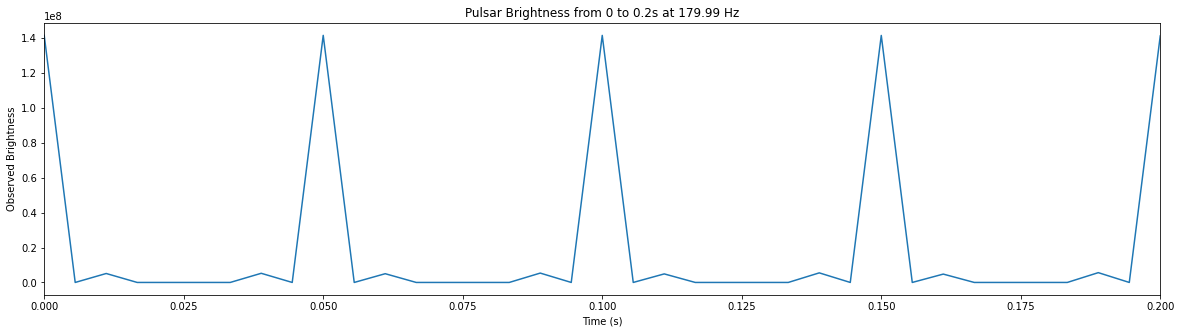

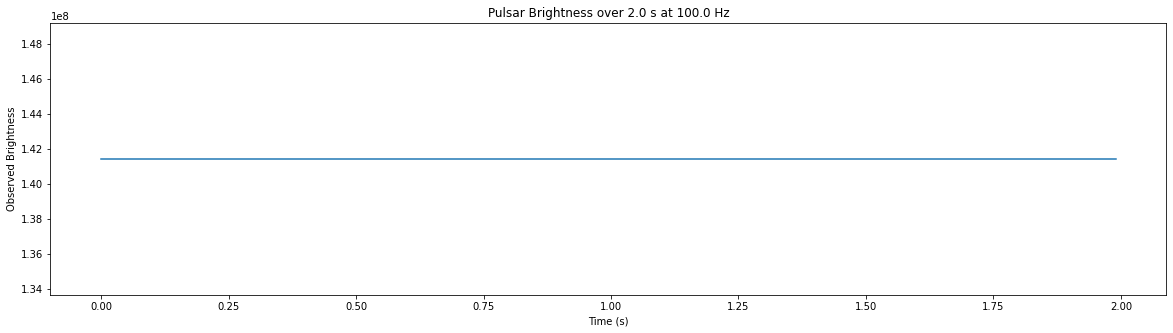

In [83]:
prate = 0.005556*s
plot_brightness(time, prate)
plot_brightness(time, prate, (0, 0.20))

prate = 0.01*s
plot_brightness(time, prate)

## Integrated Brightness

Physical detectors operate at discreet time internals. The following plot shows
a integration of the brightness profile using a $\Delta t = 0.25 \, ms$ or
$4000\, Hz$, $4\times$ faster than the pulsar frequency.

The integrated data produces a more smooth transition between peaks and troughs.
The cost is more computation time used to calculate each data chunk.

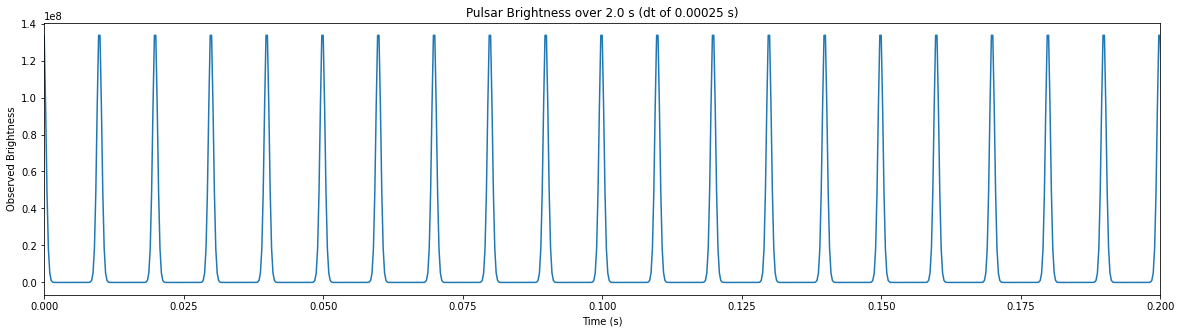

In [84]:
# Integrate the brigthness with a dt of 0.25ms
dt = 0.00025 * s # 0.25ms
steps = np.arange(0, time.value, dt.value)

brightness = pulsar.integrated_brightness(phi0, D, period, Ipeak, dt, steps)

plt.plot(steps[:-1], brightness)
plt.title(f'Pulsar Brightness over {time} (dt of {dt})')
plt.xlabel('Time (s)')
plt.ylabel('Observed Brightness')
plt.xlim(0, 0.2)
plt.show()

## Adding noise

Real data is also affected by noise. The next two plots show the same simulated
time series with a gaussian noise with a standard deviation of 20% the peak
observed brightness.

Although the frequency of pulses remains the same, the overall data trend is
less clear and a peak brightness cannot be directly inferred.

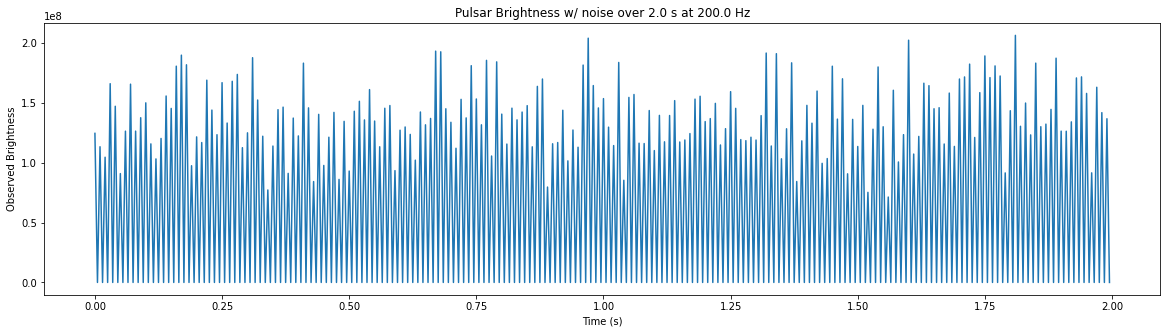

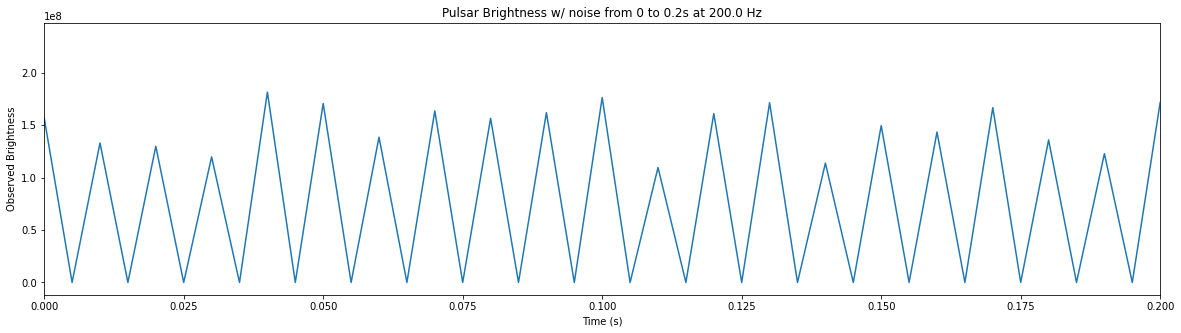

In [85]:
def plot_noisy_brightness(time: s, rate: s, xlim=()):

    timeseries = np.arange(0, time.value, rate.value) * s
    freq = (1/rate).to(Hz).round(2)
    stddev = Ipeak * 0.2
    brightness = pulsar.noisy_brightness(phi0, D, period, Ipeak, stddev,
     timeseries)

    plt.plot(timeseries, brightness)
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    if len(xlim) == 2:
        min = xlim[0]
        max = xlim[1]
        plt.xlim(xlim[0], xlim[1])
        plt.title(f'Pulsar Brightness w/ noise from {min} to {max}s at {freq}')
    else:
        plt.title(f'Pulsar Brightness w/ noise over {time} at {freq}')
    plt.show()

plot_noisy_brightness(time, rate)
plot_noisy_brightness(time, rate, (0, 0.20))

## Search templates

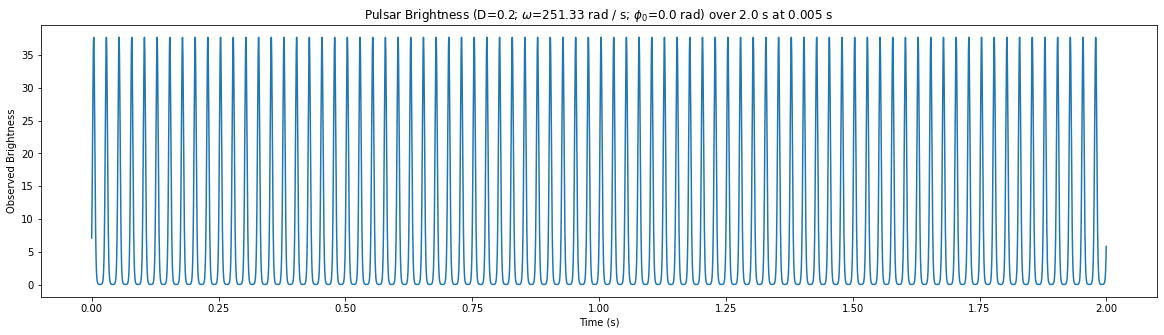

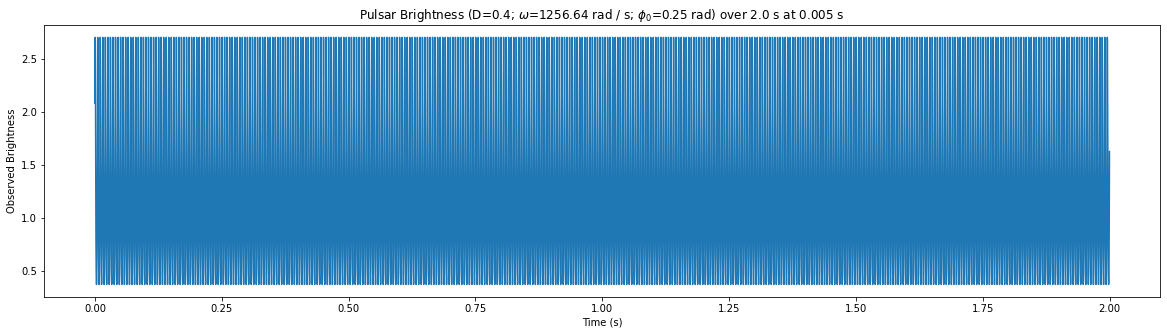

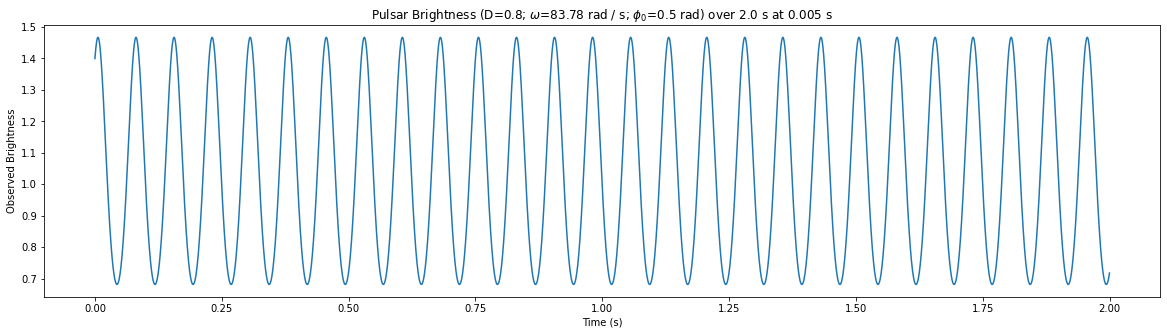

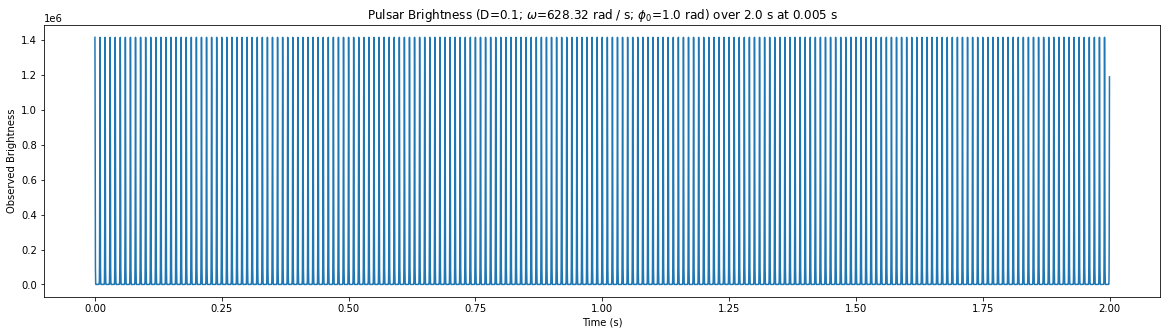

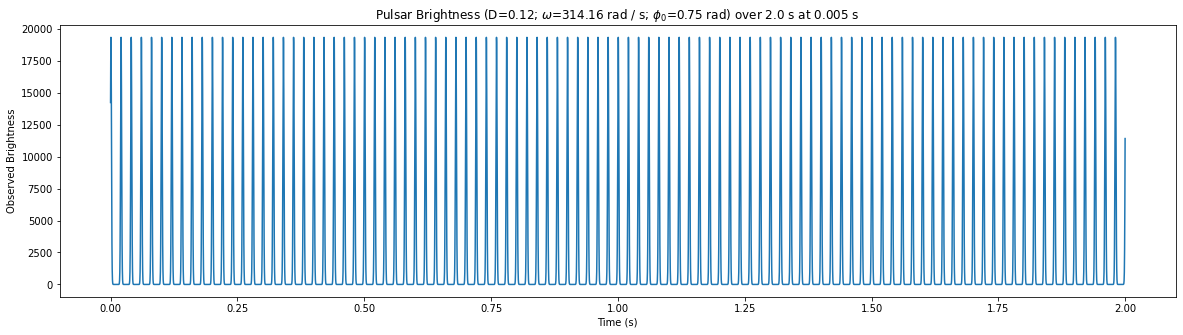

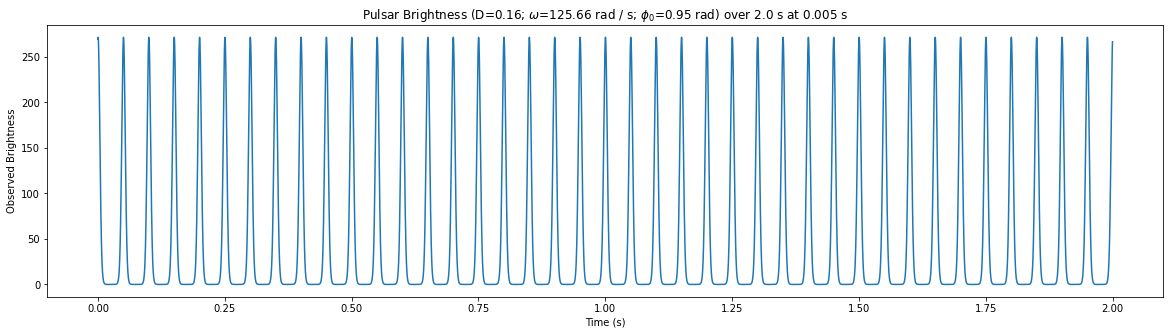

In [86]:
params = pulsar.search_parameters()
templates = pulsar.search_templates(timeseries)
for i, (D, omega, phi) in enumerate(params):
    romega = omega.round(2)
    rphi = phi.round(2)
    plt.plot(timeseries, templates[i])
    plt.xlabel('Time (s)')
    plt.ylabel('Observed Brightness')
    plt.title(fr'Pulsar Brightness (D={D}; $\omega$={romega}; $\phi_0$={rphi})'
    f' over {time} at {rate}')
    plt.show()
    